In [1]:
import os
import pandas as pd

#Se lee la base de datos
datos=pd.read_csv("C:\\Users\\ingri\\Downloads\\Reporte_Ratio_Combinado_Por_Aseguradora(1).csv")

In [2]:
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import matplotlib.pyplot as plt

In [3]:
#Filtración de la base de datos para las 4 aseguradoras de interés
datos_filtrados=datos[(datos['Aseguradora']=='INS') | (datos['Aseguradora']=='ASSA') | (datos['Aseguradora']=='PANAM') | (datos['Aseguradora']=='QUALITAS')]

#todos los datos antes del 2023
datosantesdel2023=datos_filtrados[~datos_filtrados['Periodo'].str.contains('2023', case=False)]

#Datos de los 4 trimestres del 2022
datos_2022=datos_filtrados[datos_filtrados['Periodo'].str.contains('2022', case=False)]

#Datos del 2022 y el 2023
datos_2022_2023=datos_filtrados[datos_filtrados['Periodo'].str.contains('2022', case=False) | datos_filtrados['Periodo'].str.contains('2023', case=False)]

#Datos del I trimestre del 2023
I_2023 = datos_filtrados[datos_filtrados['Periodo'].str.contains('2023', case=False)]

#Aproximación Holt Winters model un trimestre en el futuro
model_holt_winters = ExponentialSmoothing(datosantesdel2023['Ratio combinado'], trend='mul',
                                          seasonal='mul', seasonal_periods=4)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(I_2023))
forecasts_holt_winters1=pd.DataFrame(forecasts_holt_winters,columns=['holt winters'])

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [4]:
#Agregar los datos de la aproximación al dataframe de los datos del 2023
I_2023['Aprox']=forecasts_holt_winters.values
I_2023

C:\Users\ingri\AppData\Local\Temp\ipykernel_51732\378051435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  I_2023['Aprox']=forecasts_holt_winters.values


,Periodo,Aseguradora,Índice de siniestralidad,Índice de gastos,Gastos de adquisición,Gastos de administración,Comisiones y participaciones en el reaseguro cedido y retrocedido (-),Otros gastos netos,Ratio combinado,Aprox
310,I-2023,INS,68.558958,30.497483,17.344013,7.603044,1.737198,7.287625,99.056441,100.981389
313,I-2023,ASSA,55.304172,39.624752,34.114986,22.960143,33.042330,15.591953,94.928924,92.684053
314,I-2023,PANAM,62.959597,18.611132,17.730610,1.562988,6.884585,6.202119,81.570729,82.449614
317,I-2023,QUALITAS,63.866845,19.982534,22.826305,1.832913,0.048559,-4.628125,83.849379,80.414359


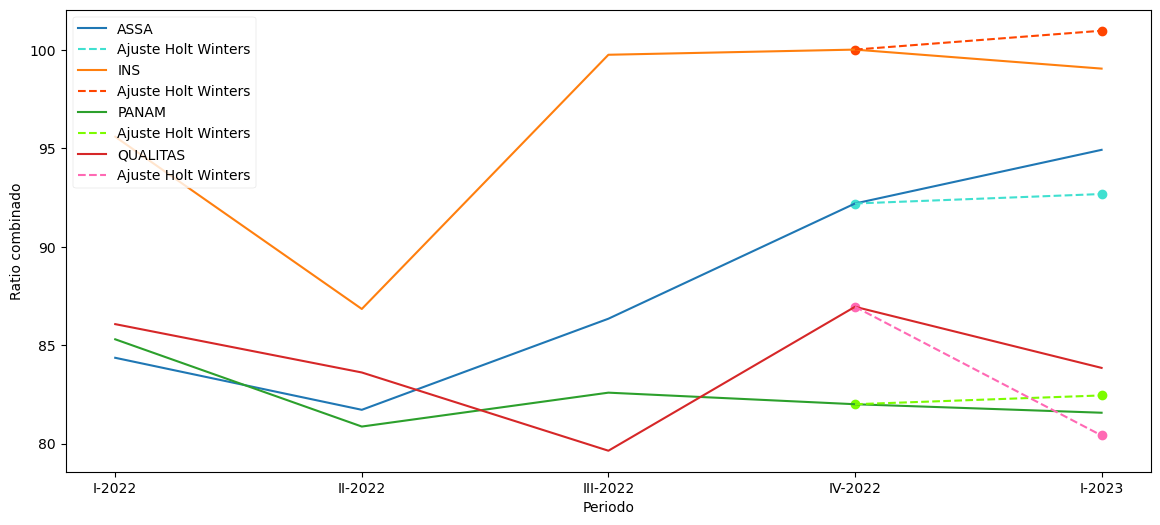

In [5]:
#Gráfica del Ratio Combinado a portir del 2022 hasta el 2023, añadiendo la aproximación Holt Winters

fig, ax = plt.subplots(figsize=(14, 6))

colores = ["turquoise" ,"orangered", "lawngreen", "hotpink"]
for i, (aseguradora, datos) in enumerate(datos_2022_2023.groupby("Aseguradora")):
    periodos = datos["Periodo"]
    ratios = datos["Ratio combinado"]
    ax.plot(periodos, ratios, label=aseguradora)
    # Datos del primer punto
    x1 = datos_2022.loc[(datos_2022['Periodo']=='IV-2022') & (datos_2022['Aseguradora']==aseguradora), 'Periodo'].iloc[0]
    y1 = datos_2022.loc[(datos_2022['Periodo']=='IV-2022') & (datos_2022['Aseguradora']==aseguradora), 'Ratio combinado'].iloc[0]
    # Datos del segundo punto
    x2 = I_2023.loc[(I_2023['Periodo']=='I-2023') & (I_2023['Aseguradora']==aseguradora), 'Periodo'].iloc[0]
    y2 = I_2023.loc[(I_2023['Periodo']=='I-2023') & (I_2023['Aseguradora']==aseguradora), 'Aprox'].iloc[0]
    # Graficamos los puntos y la línea recta correspondiente
    plt.scatter(x1, y1, color=colores[i])
    plt.scatter(x2, y2, color=colores[i])
    plt.plot([x1, x2], [y1, y2], label='Ajuste Holt Winters', linestyle='--', color=colores[i])

ax.legend(title="Aseguradoras", loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Periodo")
ax.set_ylabel("Ratio combinado")

for text in ax.legend().get_texts():
    text.set_fontsize(8)

ax.legend().get_frame().set_linewidth(0.3)
#fig.savefig('Aproximacion1')

In [6]:
#Calculo del error absoluto entre el Ratio combinado del I trimestre 2023 
#con su respectiva aproximación
I_2023['Error absoluto']=abs(I_2023['Ratio combinado']-I_2023['Aprox'])

#Calculo del error medio absoluto
error_medio = sum(I_2023['Error absoluto'])/4

C:\Users\ingri\AppData\Local\Temp\ipykernel_51732\644177906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  I_2023['Error absoluto']=abs(I_2023['Ratio combinado']-I_2023['Aprox'])
